# Remoção de Ruído de Imagens com Autoencoder - Dataset MNIST

## 1 - Importando bibliotecas

In [1]:
import os
import keras
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import gzip
import cv2
from skimage.util import random_noise
import random

from keras.optimizers import RMSprop
from keras import backend as K
import tensorflow as tf

from IPython.display import Image, SVG
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import regularizers

Using TensorFlow backend.


## 2 - Funções para importar o dataset

In [2]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data


def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

## 3 - Carregue os dados de treino e validação/teste, sabendo que são 60000 imagens de treino e 10000 imagens de validação

In [3]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

## 4 - Normalize as imagens do dataset para os pixels apresentarem valores entre 0 e 1

In [4]:
max_value = float(X_train.max())
X_train = X_train.astype('float32') / max_value
X_test = X_test.astype('float32') / max_value

## 5 - Imprima o *shape* dos dataset de treino e de validação

In [5]:
print(X_train.shape, X_test.shape)

(60000, 28, 28) (10000, 28, 28)


## 6 - Dê um reshape para que as imagens que são de escala de cinza apresentem um eixo 1 -- exemplo: transformem algo com *shape* (10000, 15, 15) em algo com *shape* (10000, 15, 15, 1).

In [6]:
X_train = X_train.reshape((len(X_train), 28, 28, 1))
X_test = X_test.reshape((len(X_test), 28, 28, 1))

In [7]:
X_train.shape

(60000, 28, 28, 1)

## 7 - Dicionário de classes, apenas para ajudar o plot de algumas imagens

In [8]:
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

## 8 - Crie uma cópia das imagens do dataset original e insira algum tipo de ruído nelas

### 8.1 Sugestão de ruídos:
### - Ruído branco gaussiano ou;
### - Ruído sal e pimenta.

### OBS: Pesquisem como incluir ruído em imagens ou em um numpy array

In [9]:
def add_noise(x,m,dp):
    n_img = x.shape[0]
    n_canal = x.shape[1]
    n_linha = x.shape[2]
    n_colun = x.shape[3]
    
    if dp == 0:
        noise = np.zeros((n_img,n_canal,n_linha,n_colun))
    else:
        noise = np.random.normal(m, dp/255., (n_img,n_canal,n_linha,n_colun))
        
    noise_x = x + noise 
    x_noise = np.clip(noise_x, 0., 1.)
    return x_noise

In [10]:
X_train_noise = add_noise(X_train,0.5,0.3)

In [11]:
X_test_noise = add_noise(X_test,0.5,0.3)

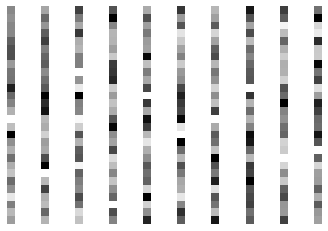

In [12]:
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(X_train_noise[i,0], cmap='gray')
    plt.axis('off')
plt.show()

## 9 - Construa o modelo de autoencoder convolucional

In [13]:
batch_size = 128
epochs = 20
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))

In [14]:
def autoencoder(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    up1 = UpSampling2D((2,2))(conv4)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2,2))(conv5)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)
    return decoded

## 10 - Crie modelo apenas do *encoder*

In [32]:
encoder = Model(input_img, autoencoder(input_img))

## 11 - Compile o modelo do *autoencoder*

In [17]:
autoencoder.compile(loss='binary_crossentropy', optimizer = 'adam')

## 12 - Treine o modelo

In [18]:
autoencoder_train = autoencoder.fit(X_train_noise, X_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,validation_data=(X_test_noise, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 356s 6ms/step - loss: 0.1192 - val_loss: 0.0766
Epoch 2/20
60000/60000 [==============================] - 373s 6ms/step - loss: 0.0751 - val_loss: 0.0724
Epoch 3/20
60000/60000 [==============================] - 334s 6ms/step - loss: 0.0721 - val_loss: 0.0704
Epoch 4/20
60000/60000 [==============================] - 333s 6ms/step - loss: 0.0707 - val_loss: 0.0694
Epoch 5/20
60000/60000 [==============================] - 330s 6ms/step - loss: 0.0697 - val_loss: 0.0686
Epoch 6/20
60000/60000 [==============================] - 330s 5ms/step - loss: 0.0690 - val_loss: 0.0684
Epoch 7/20
60000/60000 [==============================] - 330s 5ms/step - loss: 0.0684 - val_loss: 0.0678
Epoch 8/20
60000/60000 [==============================] - 330s 5ms/step - loss: 0.0680 - val_loss: 0.0676
Epoch 9/20
60000/60000 [==============================] - 331s 6ms/step - loss: 0.0676 - val_loss: 0.0

## 13 - Plot as curvas da função loss do conjunto de treino e de validação

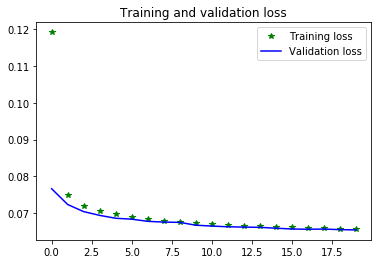

In [19]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'g*', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## 14 - Plote 10 exemplos de imagens de entrada (com ruído), vetores latentes e imagens recostruídas sem ruídos

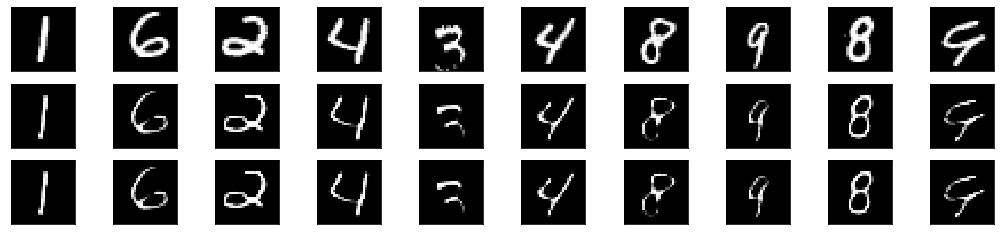

In [35]:
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(X_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(X_test)
decoded_imgs = autoencoder.predict(X_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(X_test[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()